In [67]:
import os
import json
import cv2
import numpy as np
import random
# from pycocotools.coco import COCO
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications import MobileNetV2,DenseNet121
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
import tensorflow as tf
import matplotlib.pyplot as plt


# Preparação de Dados

A base de dados PKLotSegemented possui a seguinte estrutura:
 - PUC
 - UFPR04
 - UFPR05

Cada uma dessas pastas possui mais 3 pastas, Cloudy, Rainy e Sunny
Dentro dessas pastas de clima, existem pastas separadas por datas e dentro de cada uma dessas, mais duas pastas:
- Empty
- Occupied

Que armazenam as imagens de estacionamento

In [68]:

def prepare_dataset(dataset_path):
  weather_labels = {'Rainy': 0, 'Sunny': 1, 'Cloudy': 2}
  locations = ['PUC', 'UFPR04', 'UFPR05']
  rainy_images = []
  sunny_images = []
  cloudy_images = []

  for weather, label in weather_labels.items():
    for location in locations:
      for root, _ , files in os.walk(os.path.join(dataset_path, location, weather)):
        sampled_files = random.sample(files, int(0.25 * len(files)))
        for file in sampled_files:
          if file.endswith('.jpg'):
            img_path = os.path.join(root, file)
            img = cv2.imread(img_path)
            img = cv2.resize(img, (224, 224))
            img = img_to_array(img)
            if weather == 'Rainy':
              rainy_images.append([img, label, img_path])
            elif weather == 'Sunny':
              sunny_images.append([img, label, img_path])
            elif weather == 'Cloudy':
              cloudy_images.append([img, label, img_path])

  return np.array(rainy_images, dtype=object), np.array(sunny_images, dtype=object), np.array(cloudy_images, dtype=object)

In [69]:
# Example usage
dataset_path = 'D:\\PKLot (1)\\PKLot'  # Replace with the actual path to your dataset
rainy_data, sunny_data, cloudy_data = prepare_dataset(dataset_path)

In [70]:

print(rainy_data.shape)
print(sunny_data.shape)
print(cloudy_data.shape)

(127, 3)
(1138, 3)
(725, 3)


In [71]:
print(rainy_data[0])

[array([[[ 86., 127., 110.],
         [ 77., 160., 142.],
         [ 87., 141., 131.],
         ...,
         [ 59.,  74.,  70.],
         [ 58.,  62.,  63.],
         [ 56.,  64.,  59.]],

        [[ 62.,  87.,  76.],
         [ 80., 157., 140.],
         [ 96., 144., 134.],
         ...,
         [ 66.,  90.,  82.],
         [ 56.,  74.,  70.],
         [ 57.,  85.,  79.]],

        [[ 49.,  65.,  58.],
         [ 84., 156., 139.],
         [ 95., 157., 141.],
         ...,
         [ 66.,  90.,  86.],
         [ 61.,  82.,  78.],
         [ 59.,  83.,  82.]],

        ...,

        [[133., 141., 155.],
         [ 99.,  92., 106.],
         [111., 119., 130.],
         ...,
         [ 63.,  57., 120.],
         [ 56.,  51., 109.],
         [ 51.,  49.,  85.]],

        [[132., 137., 151.],
         [ 98.,  94., 110.],
         [109., 121., 135.],
         ...,
         [ 53.,  50., 111.],
         [ 53.,  51.,  96.],
         [ 67.,  63.,  91.]],

        [[126., 134., 143.],
       

# Separa em treino e validação

In [72]:
weather_data = np.concatenate((rainy_data, sunny_data, cloudy_data))

np.random.shuffle(weather_data)

# Extrair as imagens e labels
weather_images = np.array([item[0] for item in weather_data])
weather_labels = np.array([item[1] for item in weather_data])
weather_paths = np.array([item[2] for item in weather_data])

# Modelo (Transfer Learning com MobileNetV2)

In [73]:
mobilenet_model = tf.keras.applications.MobileNetV2(input_shape=(224,224,3),
                                               include_top=False,
                                               weights='imagenet')

In [74]:
for layer in mobilenet_model.layers:
  layer.trainable = False

In [75]:
mobilenet_output = GlobalAveragePooling2D()(mobilenet_model.output)
mobilenet_model = Model(inputs=mobilenet_model.input, outputs=mobilenet_output)
mobilenet_features = mobilenet_model.predict(weather_images)

63/63 ━━━━━━━━━━━━━━━━━━━━ 23s 353ms/step


In [76]:
np.save('mobilenet_features.npy', mobilenet_features)





# Modelo (Transfer Learning com DenseNet)


In [77]:
densenet_model = tf.keras.applications.DenseNet121(input_shape=(224, 224, 3),
                                                   include_top=False,
                                                   weights="imagenet")

In [78]:
for layer in densenet_model.layers:
  layer.trainable = False

In [79]:
densenet_output = GlobalAveragePooling2D()(densenet_model.output)
densenet_model = Model(inputs=densenet_model.input, outputs=densenet_output)
densenet_features = densenet_model.predict(weather_images)

63/63 ━━━━━━━━━━━━━━━━━━━━ 73s 1s/step


# Combined Features

In [80]:
print(densenet_features.shape)
print(mobilenet_features.shape)


(1990, 1024)
(1990, 1280)


In [81]:
combined_features = np.concatenate([mobilenet_features, densenet_features], axis=-1)

# Crie e treine o classificador KNN

In [82]:
X_train, X_test, y_train, y_test = train_test_split(
    combined_features, weather_labels, test_size=0.2, random_state=42
)
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

In [83]:

accuracy = knn.score(X_test, y_test)
print(f"Acurácia do KNN: {accuracy}")

Acurácia do KNN: 0.9020100502512562


In [85]:
predictions = knn.predict(X_train)

image_predictions = [[image, prediction, path] for image, prediction, path in zip(X_test, predictions, weather_paths)]
rainy_predictions = []
cloudy_predictions = []
sunny_predictions = []

for image, prediction, image_path in image_predictions:
    xml_path = image_path.replace('.jpg', '.xml')
    if prediction == 0:
        rainy_predictions.append([image, prediction, xml_path])
    elif prediction == 1:
        sunny_predictions.append([image, prediction, xml_path])
    elif prediction == 2:
        cloudy_predictions.append([image, prediction, xml_path])

print(len(rainy_predictions))
print(len(sunny_predictions))
print(len(cloudy_predictions))

22
235
141


In [86]:
rainy_predictions[0]

[array([0.10606924, 0.43139455, 0.        , ..., 1.2523121 , 9.043868  ,
        3.5350213 ], dtype=float32),
 0,
 'D:\\PKLot (1)\\PKLot\\UFPR05\\Sunny\\2013-03-10\\2013-03-10_09_25_03.xml']

In [132]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET

def extract_data(rainy_predictions):
    rois = []
    labels = []

    for image, _, image_path in rainy_predictions:
        image = image.astype(np.uint8)
        xml_path = image_path.replace('.jpg', '.xml')
        tree = ET.parse(xml_path)
        root = tree.getroot()

        for space in root.findall('space'):
            occupied = space.get('occupied')

            if occupied is None:
                print("Atributo 'occupied' não encontrado. Pulando para o próximo espaço.")
                continue

            occupied = int(occupied)

            contour = space.find('contour')
            points = []
            for point in contour.findall('point') + contour.findall('Point'):
                x = int(point.get('x'))
                y = int(point.get('y'))
                points.append([x, y])

            points_np = np.array(points, dtype=np.int32)
            mask = np.zeros(image.shape[:2], dtype=np.uint8)

            if len(points_np) > 0:
                cv2.fillPoly(mask, [points_np], 255)
                roi = cv2.bitwise_and(image, image, mask=mask)

                if roi.size > 0:  # Verifica se ROI não está vazia
                    rois.append(roi)
                    labels.append(occupied)
                else:
                    print(f"ROI vazia para a imagem: {image_path}")

    return rois, labels




Atributo 'occupied' não encontrado. Pulando para o próximo espaço.
Atributo 'occupied' não encontrado. Pulando para o próximo espaço.
Atributo 'occupied' não encontrado. Pulando para o próximo espaço.
Atributo 'occupied' não encontrado. Pulando para o próximo espaço.
Atributo 'occupied' não encontrado. Pulando para o próximo espaço.
Atributo 'occupied' não encontrado. Pulando para o próximo espaço.
Dimensões da imagem antes do redimensionamento: 1x2304
Novo tamanho inválido: (0, 800)
Imagem 0 não pôde ser exibida devido a erros.
Dimensões da imagem antes do redimensionamento: 1x2304
Novo tamanho inválido: (0, 800)
Imagem 1 não pôde ser exibida devido a erros.
Dimensões da imagem antes do redimensionamento: 1x2304
Novo tamanho inválido: (0, 800)
Imagem 2 não pôde ser exibida devido a erros.
Dimensões da imagem antes do redimensionamento: 1x2304
Novo tamanho inválido: (0, 800)
Imagem 3 não pôde ser exibida devido a erros.
Dimensões da imagem antes do redimensionamento: 1x2304
Novo tamanh

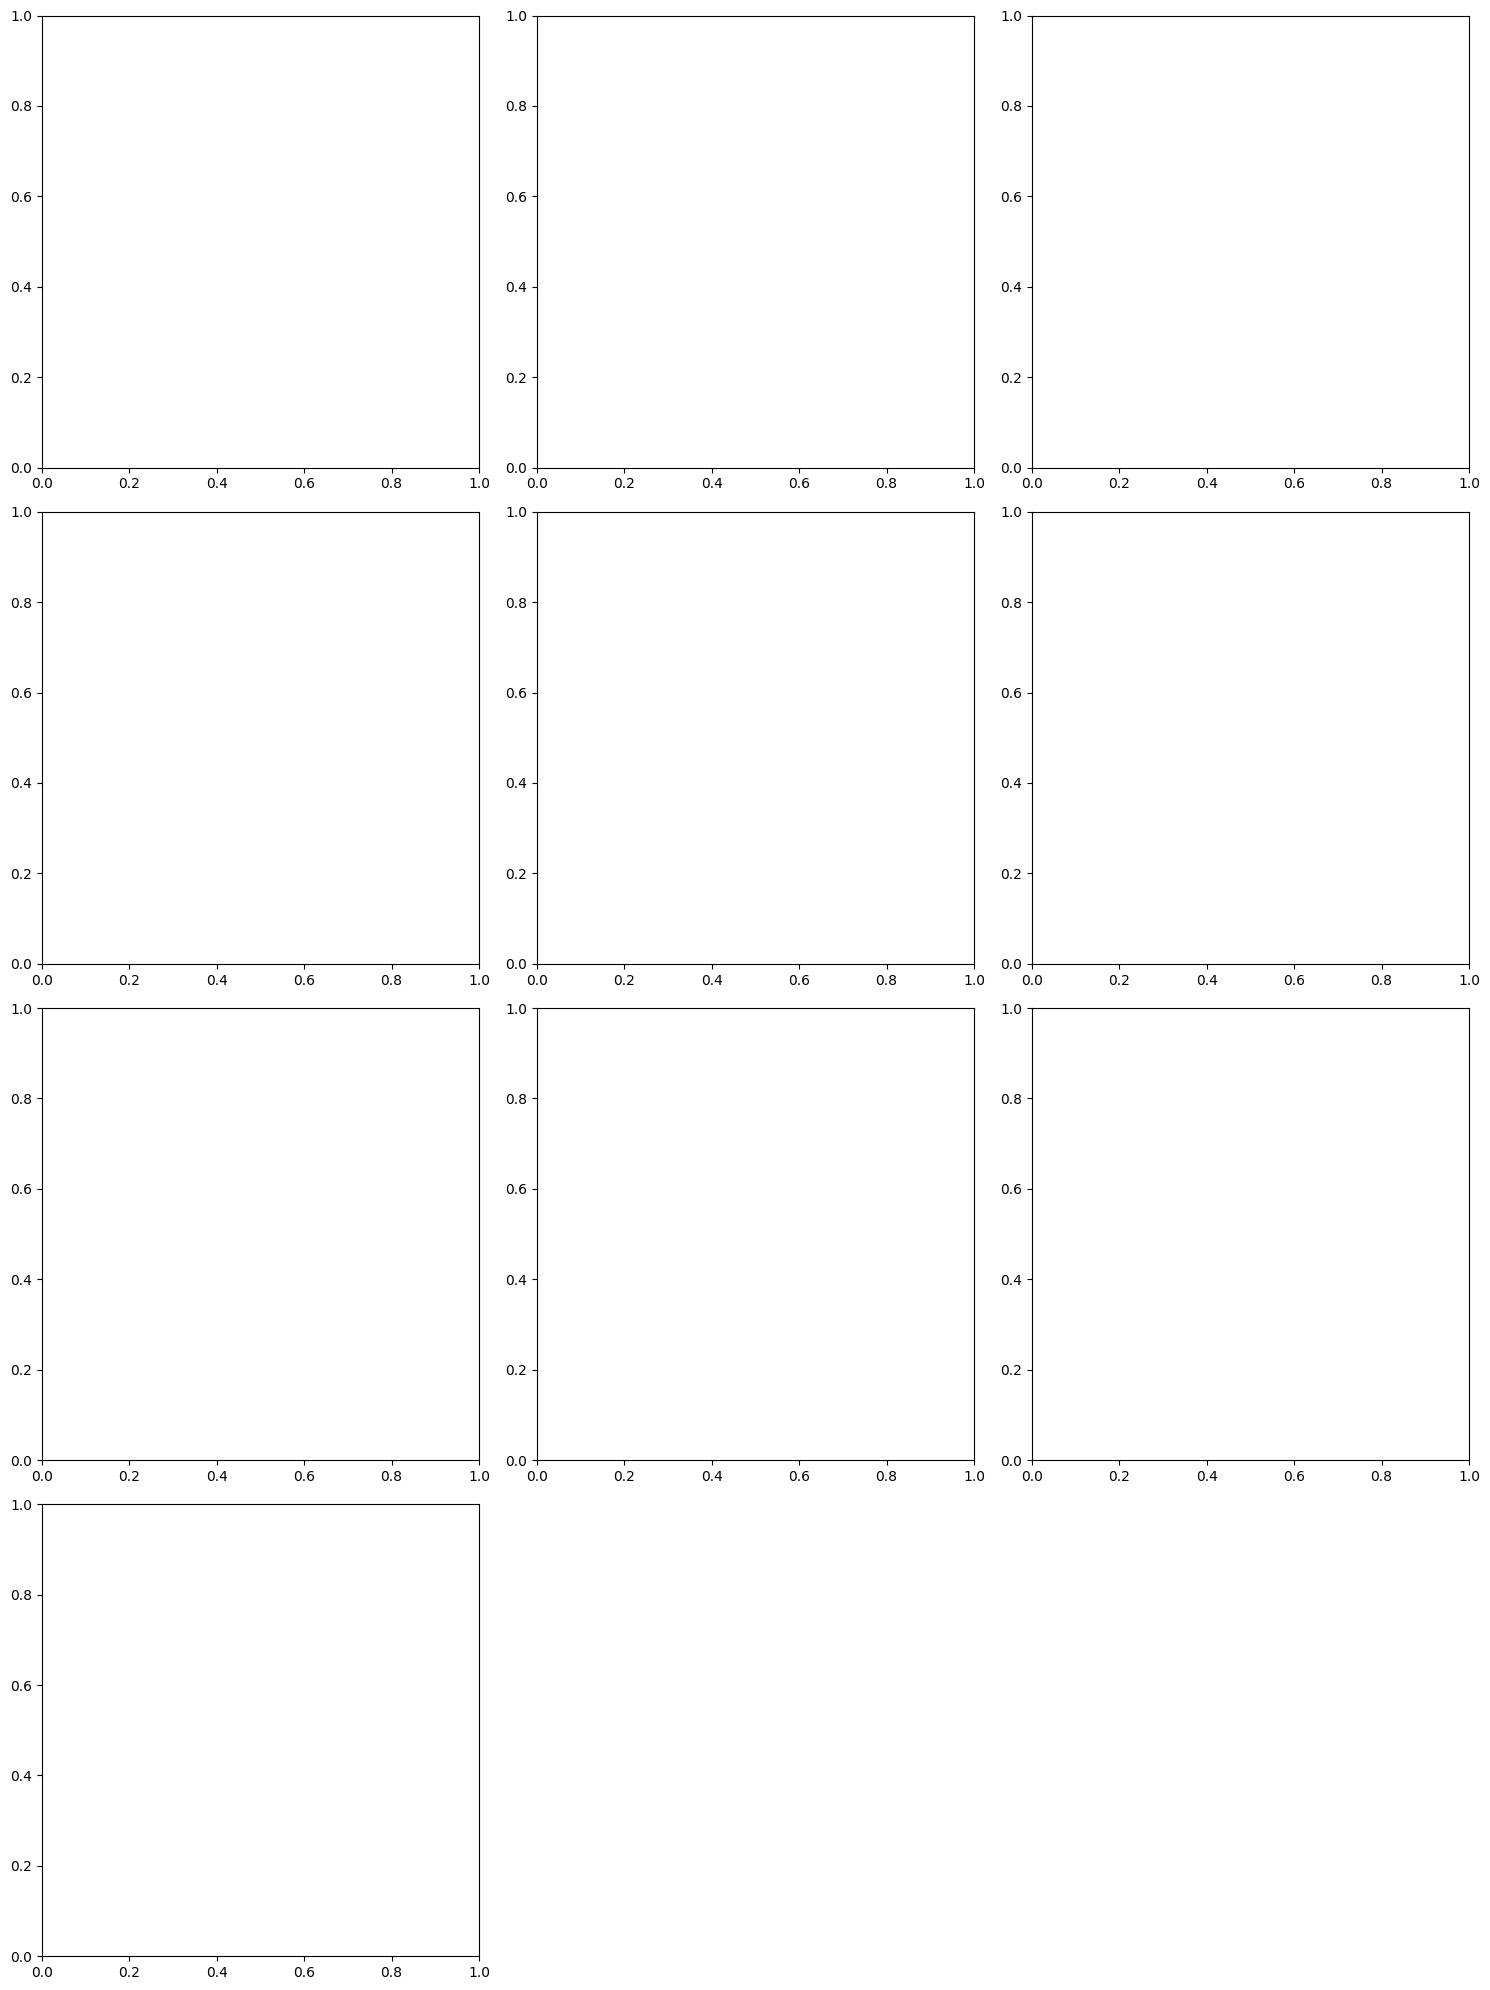

In [140]:
def resize_image(image, max_size=(800, 800)):
    if image is None or image.size == 0:
        print("Imagem vazia ou não válida.")
        return None

    height, width = image.shape[:2]
    print(f"Dimensões da imagem antes do redimensionamento: {width}x{height}")

    if height <= 0 or width <= 0:
        print(f"Dimensões inválidas da imagem: {width}x{height}")
        return None

    if height > 4000 or width > 4000:
        scaling_factor = min(4000 / height, 4000 / width)
        new_size = (int(width * scaling_factor), int(height * scaling_factor))
        image = cv2.resize(image, new_size)
        height, width = new_size  # Atualiza altura e largura após o redimensionamento

    if height > max_size[0] or width > max_size[1]:
        scaling_factor = min(max_size[0] / height, max_size[1] / width)
        new_size = (int(width * scaling_factor), int(height * scaling_factor))
        
        # Verifica novamente se new_size é válido
        if new_size[0] <= 0 or new_size[1] <= 0:
            print(f"Novo tamanho inválido: {new_size}")
            return None
        
        print(f"Redimensionando imagem para: {new_size}")
        return cv2.resize(image, new_size)

    return image


def visualize_rois(rois, labels, max_images=10):
    if not rois:
        print("Não há regiões de interesse para exibir.")
        return

    num_rois = min(len(rois), max_images)  # Limitar o número de imagens exibidas
    cols = 3
    rows = (num_rois + cols - 1) // cols

    plt.figure(figsize=(15, 5 * rows))

    for i in range(num_rois):
        plt.subplot(rows, cols, i + 1)
        resized_image = resize_image(rois[i])

        if resized_image is not None and resized_image.size > 0:
            plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
            plt.title(f'Label: {labels[i]}')
            plt.axis('off')
        else:
            print(f"Imagem {i} não pôde ser exibida devido a erros.")

    plt.tight_layout()
    plt.show()

# Exemplo de uso
rois, labels = extract_data(rainy_predictions)
visualize_rois(rois, labels)



In [119]:
xlm_path = rainy_predictions[0][2]

tree = ET.parse(xml_path)
root = tree.getroot()

for space in root.findall('space'):
  space_id = space.get('id')
  occupied = space.get('occupied')

  print(f'Espaço {space_id}: {"Ocupado" if occupied == "1" else "Livre"}')

  # Acesse outros elementos dentro de 'space', se necessário
  rotated_rect = space.find('rotatedRect')
  if rotated_rect is not None:
    center = rotated_rect.find('center')
    if center is not None:
      x = center.get('x')
      y = center.get('y')
      print(f'  Centro: x={x}, y={y}')

Espaço 1: Ocupado
  Centro: x=651, y=636
Espaço 2: Ocupado
  Centro: x=705, y=563
Espaço 3: Ocupado
  Centro: x=732, y=480
Espaço 4: Livre
  Centro: x=762, y=409
Espaço 5: Livre
  Centro: x=773, y=346
Espaço 6: Livre
  Centro: x=803, y=296
Espaço 7: Livre
  Centro: x=818, y=255
Espaço 8: Livre
  Centro: x=837, y=222
Espaço 9: Livre
  Centro: x=856, y=192
Espaço 10: Ocupado
  Centro: x=469, y=649
Espaço 11: Livre
  Centro: x=644, y=352
Espaço 12: Livre
  Centro: x=687, y=300
Espaço 13: Livre
  Centro: x=693, y=262
Espaço 14: Livre
  Centro: x=733, y=227
Espaço 15: Livre
  Centro: x=737, y=193
Espaço 16: Livre
  Centro: x=307, y=326
Espaço 17: Livre
  Centro: x=361, y=283
Espaço 18: Livre
  Centro: x=403, y=246
Espaço 19: Livre
  Centro: x=452, y=214
Espaço 20: Livre
  Centro: x=482, y=184
Espaço 21: Livre
  Centro: x=513, y=161
Espaço 22: Ocupado
  Centro: x=127, y=363
Espaço 23: Livre
  Centro: x=198, y=310
Espaço 24: Livre
  Centro: x=260, y=276
Espaço 25: Livre
  Centro: x=316, y=243